In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Finetuning

We saw in the earlier notebook that training a deep neural network requires a lot of training examples. When such a deep neural network is trained, the initial layers learn generic set of features and the later layers can be thought of as classifying those generic features. Hence, one can use pretrained features from networks that are trained on a big dataset to a new related problem where data is scarce.

In this tutorial, we will see we will learn how to train the network using transfer learning to further improve these features to our task. We will use alexnet architecture, that is trained on 1000-class ImageNet dataset. 

In this document we will perform transfer learning by two types of finetuning. First, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. Second, we start with a pretrained model and only update the final layer weights from which we derive predictions. In this we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In general both transfer learning methods follow the same few steps:
- Initialize the pretrained model
- Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
- Define for the optimization algorithm which parameters we want to update during training
- Run the training step

In [ ]:
from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import time
import os
import copy

## Input

Here are all of the parameters to change for the run. We will use the hymenoptera_data dataset which can be downloaded here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>. This dataset contains two classes, bees and ants, and is structured such that we can use the ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder> dataset, rather than writing our own custom dataset. Download the data and set the data_dir input to the root directory of the dataset. We will be using AlexNet as our deep neural network model that we wish to finetune.

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/content/drive/My Drive/Colab Notebooks/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

## Helper functions

Before we write the code for adjusting the models, lets define a few helper functions.

Model Training and Validation Code

```
The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. It also keeps track of the best performing model (in terms of validation 
accuracy), and at the end of training returns the best performing model. After each epoch, 
the training and validation accuracies are printed.
```

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute

```
This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.
```

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and reshape the network

Now to the most interesting part. Here is where we handle the reshaping of the network. Note, this is not an automatic procedure and is unique to a model. Recall, the final layer of a CNN model, which is often times an FC layer, has the same number of nodes as the number of output classes in the dataset. Since all of the models have been pretrained on Imagenet, they all have output layers of size 1000, one node for each class. The goal here is to reshape the last layer to have the same number of inputs as before, AND to have the same number of outputs as the number of classes in the dataset. In the following sections we will discuss how to alter the architecture of each model individually. But first, there is one important detail regarding the difference between the two modes of fine-tuning

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .`requires_grad` attribute to `False`. This is important because by default, this attribute is set to `True`. Then, when we initialize the new layer and by default the new parameters have `.requires_grad=True` so only the new layer’s parameters will be updated. When we are finetuning all the layers, we can leave all of the `.required_grad`’s set to the default of `True`.

Now, we will specifically look at Alexnet. Alexnet was introduced in the paper ImageNet Classification with Deep Convolutional Neural Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>__ and was the first very successful CNN on the ImageNet dataset. When we print the model architecture, we see the model output comes from the 6th layer of the classifier

::
```
(classifier): Sequential( ... (6): Linear(in_features=4096, out_features=1000, bias=True) )
```
To use the model with our dataset we reinitialize this layer as

::

`model.classifier[6] = nn.Linear(4096,num_classes)`

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


## Load Data

Now that we know what the input size must be, we can initialize the data transforms, image datasets, and the dataloaders. Notice, the models were pretrained with the hard-coded normalization values, as described here <https://pytorch.org/docs/master/torchvision/models.html>__.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Create the Optimizer

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that all parameters that have
``.requires_grad=True`` should be optimized. Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Run Training and Validation Step

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.5769 Acc: 0.7623
val Loss: 0.3130 Acc: 0.8889

Epoch 1/14
----------
train Loss: 0.3536 Acc: 0.8934
val Loss: 0.3285 Acc: 0.9085

Epoch 2/14
----------
train Loss: 0.1691 Acc: 0.9262
val Loss: 0.4107 Acc: 0.9020

Epoch 3/14
----------
train Loss: 0.2943 Acc: 0.9180
val Loss: 0.4814 Acc: 0.9085

Epoch 4/14
----------
train Loss: 0.3329 Acc: 0.9057
val Loss: 0.4670 Acc: 0.8889

Epoch 5/14
----------
train Loss: 0.3136 Acc: 0.9016
val Loss: 0.5571 Acc: 0.8954

Epoch 6/14
----------
train Loss: 0.2266 Acc: 0.9262
val Loss: 0.4231 Acc: 0.9020

Epoch 7/14
----------
train Loss: 0.2168 Acc: 0.9139
val Loss: 0.4628 Acc: 0.8954

Epoch 8/14
----------
train Loss: 0.2200 Acc: 0.9262
val Loss: 0.4538 Acc: 0.9150

Epoch 9/14
----------
train Loss: 0.1774 Acc: 0.9467
val Loss: 0.3765 Acc: 0.9150

Epoch 10/14
----------
train Loss: 0.1394 Acc: 0.9508
val Loss: 0.3471 Acc: 0.9020

Epoch 11/14
----------
train Loss: 0.1620 Acc: 0.9549
val Loss: 0.4873 Acc: 0.8889

Ep

## Comparison with Model Trained from Scratch

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.

Epoch 0/14
----------
train Loss: 0.6939 Acc: 0.4959
val Loss: 0.6944 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6938 Acc: 0.4631
val Loss: 0.6930 Acc: 0.5098

Epoch 2/14
----------
train Loss: 0.6933 Acc: 0.5000
val Loss: 0.6924 Acc: 0.5425

Epoch 3/14
----------
train Loss: 0.6936 Acc: 0.4877
val Loss: 0.6917 Acc: 0.5425

Epoch 4/14
----------
train Loss: 0.6928 Acc: 0.5492
val Loss: 0.6922 Acc: 0.5882

Epoch 5/14
----------
train Loss: 0.6928 Acc: 0.5000
val Loss: 0.6924 Acc: 0.6275

Epoch 6/14
----------
train Loss: 0.6926 Acc: 0.5287
val Loss: 0.6919 Acc: 0.6601

Epoch 7/14
----------
train Loss: 0.6925 Acc: 0.5287
val Loss: 0.6926 Acc: 0.4706

Epoch 8/14
----------
train Loss: 0.6928 Acc: 0.5082
val Loss: 0.6919 Acc: 0.6144

Epoch 9/14
----------
train Loss: 0.6927 Acc: 0.5533
val Loss: 0.6914 Acc: 0.6536

Epoch 10/14
----------
train Loss: 0.6923 Acc: 0.5820
val Loss: 0.6909 Acc: 0.6405

Epoch 11/14
----------
train Loss: 0.6928 Acc: 0.5287
val Loss: 0.6893 Acc: 0.5556

Ep

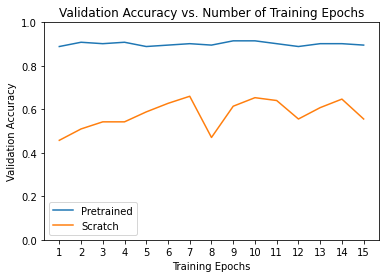

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Excercise
Try finetuning the entire pretrained model. Report the best accuracy achieved. Does this model work better or worse than only fine-tuning the final layer? Report your result with and without using weight decay for both approaches.

## Excercise (optional)

Try changing the number of layers to finetune. You can choose to finetune the train only a two of the last fully connected layers.

In [ ]:
### Your code here ###